In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

 Anomaly detection¶

 train an autoencoder to detect anomalies on the ECG5000 dataset. This dataset contains 5,000 Electrocardiograms, each with 140 data points.  will use a simplified version of the dataset, where each example has been labeled either 0 (corresponding to an abnormal rhythm), or 1 (corresponding to a normal rhythm).we are interested in identifying the abnormal rhythms.


How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

In [ ]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


##industrial standard


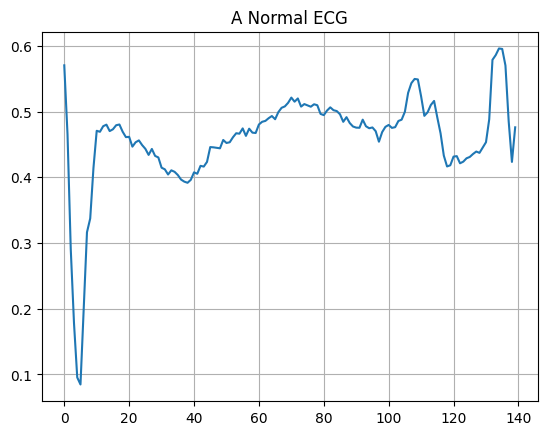

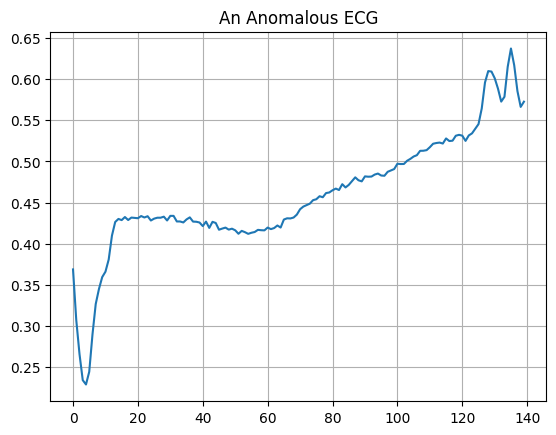

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - loss: 0.0580 - val_loss: 0.0532
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0561 - val_loss: 0.0514
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0535 - val_loss: 0.0493
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0499 - val_loss: 0.0476
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0457 - val_loss: 0.0466
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0419 - val_loss: 0.0448
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0383 - val_loss: 0.0426
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0349 - val_loss: 0.0415
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0323 - val_loss: 0.0407
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0303 - val_loss: 0.0395
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0288 - val_loss: 0.0388
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0275 - val_loss: 0.0380


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class ECGAnomalyDetector:
    """
    Anomaly detector for ECG data using an autoencoder model.
    """

    def __init__(self, input_shape):
        """
        Initializes the model architecture and prepares for training.

        Args:
            input_shape (int): The shape of input data.
        """
        self.autoencoder = self._build_model(input_shape)

    def _build_model(self, input_shape):
        """
        Builds the autoencoder model for anomaly detection.

        Args:
            input_shape (int): Shape of the input data.

        Returns:
            tf.keras.Model: Compiled autoencoder model.
        """
        input_layer = tf.keras.layers.Input(shape=(input_shape,))  # Define an input layer
        encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])

        decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(input_shape, activation="sigmoid")
        ])

        # Call encoder and decoder with the input layer
        encoded = encoder(input_layer)
        decoded = decoder(encoded)

        # Create the autoencoder model
        autoencoder = Model(input_layer, decoded)
        autoencoder.compile(optimizer='adam', loss='mae')
        return autoencoder

    def train(self, train_data, val_data, epochs=20, batch_size=512):
        """
        Trains the autoencoder on the training data.

        Args:
            train_data (np.ndarray): Training data.
            val_data (np.ndarray): Validation data.
            epochs (int): Number of epochs for training.
            batch_size (int): Size of training batches.

        Returns:
            tf.keras.callbacks.History: Training history object.
        """
        return self.autoencoder.fit(
            train_data, train_data,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(val_data, val_data),
            shuffle=True
        )

    def predict(self, data):
        """
        Generates reconstructions for input data.

        Args:
            data (np.ndarray): Input data.

        Returns:
            np.ndarray: Reconstructed data.
        """
        return self.autoencoder.predict(data)

    def calculate_loss(self, data):
        """
        Calculates the reconstruction loss.

        Args:
            data (np.ndarray): Input data.

        Returns:
            np.ndarray: Mean Absolute Error for each sample.
        """
        reconstructions = self.predict(data)
        return tf.keras.losses.mae(reconstructions, data)


def load_and_preprocess_data(url):
    """
    Loads and preprocesses ECG dataset.

    Args:
        url (str): URL of the dataset.

    Returns:
        tuple: Processed data and labels split for training and testing.
    """
    dataframe = pd.read_csv(url, header=None)
    raw_data = dataframe.values
    labels = raw_data[:, -1]
    data = raw_data[:, :-1]

    train_data, test_data, train_labels, test_labels = train_test_split(
        data, labels, test_size=0.2, random_state=21
    )

    min_val = tf.reduce_min(train_data)
    max_val = tf.reduce_max(train_data)
    train_data = (train_data - min_val) / (max_val - min_val)
    test_data = (test_data - min_val) / (max_val - min_val)

    return tf.cast(train_data, tf.float32), tf.cast(test_data, tf.float32), train_labels.astype(bool), test_labels.astype(bool)


def plot_ecg(ecg_data, title):
    """
    Plots ECG data.

    Args:
        ecg_data (np.ndarray): ECG data to plot.
        title (str): Title of the plot.
    """
    plt.grid()
    plt.plot(np.arange(len(ecg_data)), ecg_data)
    plt.title(title)
    plt.show()


def evaluate_model(predictions, labels):
    """
    Evaluates the model performance.

    Args:
        predictions (np.ndarray): Model predictions.
        labels (np.ndarray): True labels.
    """
    print("Accuracy = ", accuracy_score(labels, predictions))
    print("Precision = ", precision_score(labels, predictions))
    print("Recall = ", recall_score(labels, predictions))


def main():
    # Load data
    data_url = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
    train_data, test_data, train_labels, test_labels = load_and_preprocess_data(data_url)

    # Separate normal and anomalous data
    normal_train_data = train_data[train_labels]
    normal_test_data = test_data[test_labels]
    anomalous_test_data = test_data[~test_labels]

    # Plot examples
    plot_ecg(normal_train_data[0], "A Normal ECG")
    plot_ecg(anomalous_test_data[0], "An Anomalous ECG")

    # Train model
    detector = ECGAnomalyDetector(input_shape=140)
    detector.train(normal_train_data, test_data)

    # Calculate threshold
    train_loss = detector.calculate_loss(normal_train_data)
    threshold = np.mean(train_loss) + np.std(train_loss)
    print("Threshold: ", threshold)

    # Evaluate model
    test_loss = detector.calculate_loss(test_data)
    predictions = test_loss < threshold
    evaluate_model(predictions, test_labels)


if __name__ == "__main__":
    main()


##both normal and abnormal

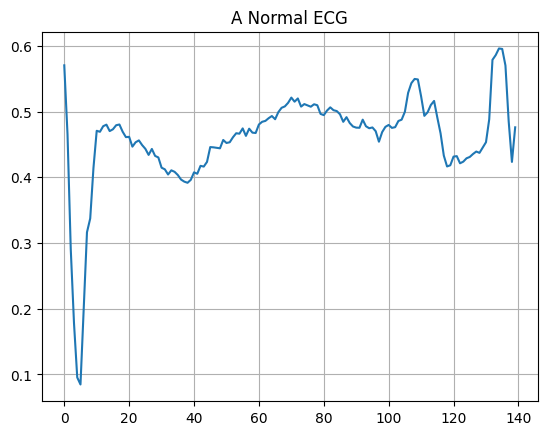

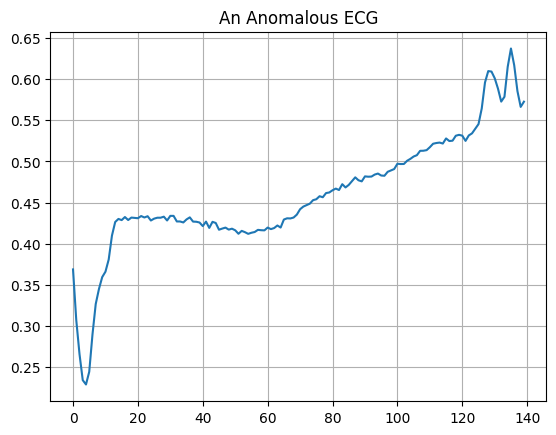

Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0545 - val_loss: 0.0519
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0511 - val_loss: 0.0483
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0475 - val_loss: 0.0448
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0439 - val_loss: 0.0414
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0404 - val_loss: 0.0384
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0374 - val_loss: 0.0360
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0349 - val_loss: 0.0339
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0330 - val_loss: 0.0321
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0310 - val_loss: 0.0304
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0296 - val_loss: 0.0289
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0281 - val_loss: 0.0277
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0267 - val_loss: 0.0266
Epoch 13/2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

class ECGAnomalyDetector:
    """
    Anomaly detector for ECG data using an autoencoder model.
    """

    def __init__(self, input_shape):
        """
        Initializes the model architecture and prepares for training.

        Args:
            input_shape (int): The shape of input data.
        """
        self.autoencoder = self._build_model(input_shape)

    def _build_model(self, input_shape):
        """
        Builds the autoencoder model for anomaly detection.

        Args:
            input_shape (int): Shape of the input data.

        Returns:
            tf.keras.Model: Compiled autoencoder model.
        """
        input_layer = tf.keras.layers.Input(shape=(input_shape,))  # Define an input layer
        encoder = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(16, activation="relu"),
            layers.Dense(8, activation="relu")
        ])

        decoder = tf.keras.Sequential([
            layers.Dense(16, activation="relu"),
            layers.Dense(32, activation="relu"),
            layers.Dense(input_shape, activation="sigmoid")
        ])

        # Call encoder and decoder with the input layer
        encoded = encoder(input_layer)
        decoded = decoder(encoded)

        # Create the autoencoder model
        autoencoder = Model(input_layer, decoded)
        autoencoder.compile(optimizer='adam', loss='mae')
        return autoencoder

    def train(self, train_data, val_data, epochs=20, batch_size=512):
        """
        Trains the autoencoder on the training data.

        Args:
            train_data (np.ndarray): Training data.
            val_data (np.ndarray): Validation data.
            epochs (int): Number of epochs for training.
            batch_size (int): Size of training batches.

        Returns:
            tf.keras.callbacks.History: Training history object.
        """
        return self.autoencoder.fit(
            train_data, train_data,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(val_data, val_data),
            shuffle=True
        )

    def predict(self, data):
        """
        Generates reconstructions for input data.

        Args:
            data (np.ndarray): Input data.

        Returns:
            np.ndarray: Reconstructed data.
        """
        return self.autoencoder.predict(data)

    def calculate_loss(self, data):
        """
        Calculates the reconstruction loss.

        Args:
            data (np.ndarray): Input data.

        Returns:
            np.ndarray: Mean Absolute Error for each sample.
        """
        reconstructions = self.predict(data)
        return tf.keras.losses.mae(reconstructions, data)


def load_and_preprocess_data(url):
    """
    Loads and preprocesses ECG dataset.

    Args:
        url (str): URL of the dataset.

    Returns:
        tuple: Processed data and labels split for training and testing.
    """
    dataframe = pd.read_csv(url, header=None)
    raw_data = dataframe.values
    labels = raw_data[:, -1]
    data = raw_data[:, :-1]

    train_data, test_data, train_labels, test_labels = train_test_split(
        data, labels, test_size=0.2, random_state=21
    )

    min_val = tf.reduce_min(train_data)
    max_val = tf.reduce_max(train_data)
    train_data = (train_data - min_val) / (max_val - min_val)
    test_data = (test_data - min_val) / (max_val - min_val)

    return tf.cast(train_data, tf.float32), tf.cast(test_data, tf.float32), train_labels.astype(bool), test_labels.astype(bool)


def plot_ecg(ecg_data, title):
    """
    Plots ECG data.

    Args:
        ecg_data (np.ndarray): ECG data to plot.
        title (str): Title of the plot.
    """
    plt.grid()
    plt.plot(np.arange(len(ecg_data)), ecg_data)
    plt.title(title)
    plt.show()


def evaluate_model(predictions, labels):
    """
    Evaluates the model performance.

    Args:
        predictions (np.ndarray): Model predictions.
        labels (np.ndarray): True labels.
    """
    print("Accuracy = ", accuracy_score(labels, predictions))
    print("Precision = ", precision_score(labels, predictions))
    print("Recall = ", recall_score(labels, predictions))


def main():
    # Load data
    data_url = 'http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv'
    train_data, test_data, train_labels, test_labels = load_and_preprocess_data(data_url)

    # Separate normal and anomalous data
    normal_train_data = train_data[train_labels]
    normal_test_data = test_data[test_labels]
    anomalous_test_data = test_data[~test_labels]

    # Plot examples
    plot_ecg(normal_train_data[0], "A Normal ECG")
    plot_ecg(anomalous_test_data[0], "An Anomalous ECG")

    # Train model
    detector = ECGAnomalyDetector(input_shape=140)
    detector.train(train_data, test_data)

    # Calculate threshold
    train_loss = detector.calculate_loss(normal_train_data)
    threshold = np.mean(train_loss) + np.std(train_loss)
    print("Threshold: ", threshold)

    # Evaluate model
    test_loss = detector.calculate_loss(test_data)
    predictions = test_loss < threshold
    evaluate_model(predictions, test_labels)


if __name__ == "__main__":
    main()
